In [1]:
from pytfa.io.json import load_json_model
from skimpy.io.yaml import  load_yaml_model
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations, load_fluxes
from skimpy.core.parameters import ParameterValues
from skimpy.utils.namespace import *
from skimpy.core.modifiers import *
from skimpy.io.yaml import load_yaml_model
from skimpy.core.reactor import Reactor
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations, load_fluxes
from skimpy.viz.plotting import timetrace_plot
from pytfa.io.json import load_json_model
from skimpy.io.yaml import load_yaml_model
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations
from skimpy.core.parameters import load_parameter_population
from skimpy.simulations.reactor import make_batch_reactor
from skimpy.core.solution import ODESolutionPopulation
from skimpy.utils.namespace import *
from skimpy.viz.escher import animate_fluxes, plot_fluxes
import copy
from skimpy.io.yaml import export_to_yaml
from skimpy.analysis.ode.utils import make_flux_fun

import pandas as pd
import numpy as np

#import seaborn as sns
import skimpy
import time
import matplotlib.pyplot as plt
import itertools
import matplotlib
import sys
sys.path.insert(1, '../functions/')

# benchmark functions
import simulation_functions as sf
import scenarios as sc
import visualizations as vis
import noise as noise
import comb_sampling as cs

#ML methods
from sklearn import svm
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import  AdaBoostRegressor
from scipy.stats import linregress

from skopt import BayesSearchCV
import seaborn as sns
from scipy.stats import entropy
from sklearn.utils import shuffle
from scipy.integrate import simpson

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [2]:
a=time.time()
def find_set_designs(comb_space,tcart,enz_names):
    """finds the training or test set designs in the combinatorial space
    Number of features has to be given
    - combinatorial space
    - cart of either the training scenario or the test set
    - enzyme names"""
    temp=0
    tset = pd.DataFrame()
    for design in tcart:
        sub=comb_space
        sub=sub.loc[sub['vmax_forward_Enzyme_A']==design[0]]
        sub=sub.loc[sub['vmax_forward_Enzyme_B']==design[1]]
        sub=sub.loc[sub['vmax_forward_Enzyme_C']==design[2]]
        sub=sub.loc[sub['vmax_forward_Enzyme_D']==design[3]]
        sub=sub.loc[sub['vmax_forward_Enzyme_E']==design[4]]
        sub=sub.loc[sub['vmax_forward_Enzyme_F']==design[5]]
        sub=sub.loc[sub['vmax_forward_Enzyme_G']==design[6]]
        tset=pd.concat([tset,sub])
    return tset,tcart


def check_if_unique(train_x):
    my_list=[]
    number_of_elements=0
    indices_to_remove=[]
    """Check whether designs are all unique in the training data"""
    for i in range(np.shape(train_x)[0]):
        my_list.append(tuple(train_x.iloc[i,:]))
    for i in range(len(my_list)):
        for j in range(len(my_list)):
            if i!=j:
                if my_list[i]==my_list[j]:
                    number_of_elements+=1
                    indices_to_remove.append(i)
    return indices_to_remove,number_of_elements
                    



def add_training_data(training_df,params):
    """Adds data to the already existing DBTL training data"""
    params2=params 
    #correct sampling strategy from four options
    if params['sampling_strategy']=="equal":
        cyc_designs,cyc_cart=sc.scenario1(params['perturb_range'],params['N_designs'],params['enz_names'])
        training_cyc,training_cart=find_set_designs(params['combinatorial_space'],cyc_cart,params['enz_names']) 
    elif params['sampling_strategy']=="radical":
        cyc_designs,cyc_cart=sc.scenario2(params['perturb_range'],params['N_designs'],params['enz_names'])
        training_cyc,training_cart=find_set_designs(params['combinatorial_space'],cyc_cart,params['enz_names']) 
    elif params['sampling_strategy']=="non-radical":
        cyc_designs,cyc_cart=sc.scenario3(params['perturb_range'],params['N_designs'],params['enz_names'])
        training_cyc,training_cart=find_set_designs(params['combinatorial_space'],cyc_cart,params['enz_names']) 
    elif params['sampling_strategy']=="manual":
        cyc_designs,cyc_cart=sc.manual_scenario(params['perturb_range'],params['N_designs'],
                                                params['probability_matrix'],params['enz_names'])
        training_cyc,training_cart=find_set_designs(params['combinatorial_space'],cyc_cart,params['enz_names']) 
    
    #add noise
    if params['noise_model']=="homoschedastic":
        noise_G=noise.add_homoschedastic_noise(training_cyc['Enzyme_G'],params['noise_percentage'])
    elif params['noise_model']=="heteroschedastic":
        noise_G=noise.add_heteroschedastic_noise(training_cyc['Enzyme_G'],params['noise_percentage'])
    
    training_cyc['Enzyme_G']=noise_G
    dfs=[training_df,training_cyc]
    training_df=pd.concat(dfs)
    
    #Check whether all items are unique, if not, add data for scenario
    remove_ind,number_of_elements=check_if_unique(training_df)
    while number_of_elements!=0:
        training_df=training_df.drop(training_df.index[remove_ind])
        params2['N_designs']=number_of_elements
        cyc_designs,cyc_cart=sc.manual_scenario(params2['perturb_range'],params2['N_designs'],
                                                params2['probability_matrix'],params2['enz_names'])
        training_cyc,training_cart=find_set_designs(params['combinatorial_space'],cyc_cart,params['enz_names']) 
            #add noise
        if params2['noise_model']=="homoschedastic":
            noise_G=noise.add_homoschedastic_noise(training_cyc['Enzyme_G'],params2['noise_percentage'])
        elif params2['noise_model']=="heteroschedastic":
            noise_G=noise.add_heteroschedastic_noise(training_cyc['Enzyme_G'],params2['noise_percentage'])
        
        training_cyc['Enzyme_G']=noise_G
        dfs=[training_df,training_cyc]
        training_df=pd.concat(dfs)
        remove_ind,number_of_elements=check_if_unique(training_df)
    
    #training and test split
    train_x=training_df[enz_names]
    train_y=training_df['Enzyme_G']
    return train_x,train_y,training_df


def train_model(params,train_x,train_y):
    if params['ML_model']=="GradientBoostingRegressor":
        #random forest 
        regr_gbr = BayesSearchCV(
        GradientBoostingRegressor(),
        {
            "min_samples_split":(2,3,4,5,6,7),
            "min_samples_leaf":(2,3,4,5,6,7),
            "max_depth": (1,2,3,4,5,7),
            "learning_rate":(0.0001,0.001,0.01,0.1,0.2,0.3),
        },
        n_iter=20,
        cv=5)
        regr_gbr.fit(train_x,train_y)
    return regr_gbr

def get_probability_matrix(prediction,params,plotting=False):
    """Given the predictive model, use the AUC for each promoter strength and enzyme 
    as a probability distribution to sample from
    
    INPUT:
    --> prediction: prediction of the full combinatorial space for your model
    --> params"""
    comb_space=params['combinatorial_space']
    pred_comb_space=comb_space.copy()
    pred_comb_space['Enzyme_G']=prediction.copy()
    threshold,matrix_pred,remaining_designs_pred=cs.scan_combinatorial_space(pred_comb_space,
                                                                             params['perturb_range'],
                                                                             params['enz_names'],0.005)
    
    enz_numbers,sorted_entropies,probability_matrix=cs.get_feature_importance(matrix_pred,pred_comb_space)
    if plotting==True:
        enzyme_x=input("Enzyme number:")
        enz=int(enzyme_x)
        A025=[]
        A05=[]
        A1=[]
        A15=[]
        A2=[]
        A4=[]
        for i in range(np.shape(matrix_pred)[2]):
            A025.append(matrix_pred[0,enz,i])
            A05.append(matrix_pred[1,enz,i])
            A1.append(matrix_pred[2,enz,i])
            A15.append(matrix_pred[3,enz,i])
            A2.append(matrix_pred[4,enz,i])
            A4.append(matrix_pred[5,enz,i])    
        plt.plot(threshold,A025,label="0.25",linewidth=2)
        plt.plot(threshold,A05,label="0.5",linewidth=2)
        plt.plot(threshold,A1,label="1",linewidth=2)
        plt.plot(threshold,A15,label="1.5",linewidth=2)
        plt.plot(threshold,A2,label="2",linewidth=2)
        plt.plot(threshold,A4,label="4",linewidth=2)
        #plt.plot(threshold,remaining_designs,c="black",label="Remaining designs space",linewidth=3,linestyle="--")
        plt.axhline(1/6,c="black",linestyle="--")
        plt.legend(title="Promoter strength",bbox_to_anchor=(1.,1))
        plt.ylabel("Frequency")
        plt.xlabel("Relative flux increase")
        plt.title(str(params['enz_names'][enz]))
        plt.show()
    return enz_numbers,sorted_entropies,probability_matrix,matrix_pred


def DBTL(training_df,params,plotting=False):
    """Wrapper function for the DBTL cycle simulation
    Input: training dataframe, parameters
    Output:
    training_df: the training dataframe for the next cycle
    enz_numbers: ordered enz numbers based on feature importance
    sorted_entropies: order entropies of the enz_numbers
    probability matrix: sampling distribution for the next cycle
    top100: intersection value of the top 100 prediction
    top100_designs: the designs in the predicted top 100 (to check when best design is found
    score: r2 value"""
    train_x,train_y,training_df=add_training_data(training_df, params)
    GBR=train_model(params,train_x,train_y)
    prediction=GBR.predict(test_x)

    #evaluate
    slope, intercept, r_value, p_value, std_err = linregress(test_y,prediction)
    score=r_value**2
    top100=np.argsort(test_y)[::-1][0:100]
    top100_pred=np.argsort(prediction)[::-1][0:100]
    top100=len(np.intersect1d(top100,top100_pred))
    top100_designs=top100_pred
    print(score,top100)
    #prepare next cycle
    enz_numbers,sorted_entropies,probability_matrix,matrix_pred=get_probability_matrix(prediction,params,plotting=plotting)  
    return training_df,enz_numbers,sorted_entropies,probability_matrix,top100,top100_designs,score

def find_top1_design(top100_designs,params):
    """finds whether the top design is in the predicted top 100, returns a binary (0 is nope, 1 is yep)"""
    comb_space=params['combinatorial_space']
    binary=0
    x=list(np.argsort(comb_space['Enzyme_G'])[::-1])
    top_ind=x[0]
    y=np.argwhere(top100_designs==top_ind)
    if len(y)==1:
        binary=1
    else:
        binary=0
    
    return binary


        

In [3]:
#Load simulations
comb_space=pd.read_csv("../data/combinatorial_space/combinatorial_space_pathway_A.csv")

#enzyme names and perturbation range
enz_names=["vmax_forward_Enzyme_A","vmax_forward_Enzyme_B","vmax_forward_Enzyme_C","vmax_forward_Enzyme_D",
           "vmax_forward_Enzyme_E","vmax_forward_Enzyme_F","vmax_forward_Enzyme_G"] #'vmax_forward_LDH_D',
perturb_range=[0.25,0.5,1,1.5,2,4]
designs,cart=sf.generate_perturbation_scheme(enz_names,perturb_range)
N_designs=50
noise_percentage=0.04


params={
    "sampling_strategy":"equal", #equal, radical, non-radical, manual (requires probability matrix)
    "combinatorial_space": comb_space,
    "noise_model":"homoschedastic",
    "noise_percentage":0.15,
    "perturb_range":perturb_range,
    "N_designs":50,
    "ML_model": "GradientBoostingRegressor",
    "probability_matrix":None,
    "enz_names":enz_names}


test_x=comb_space[enz_names]
test_y=comb_space['Enzyme_G']

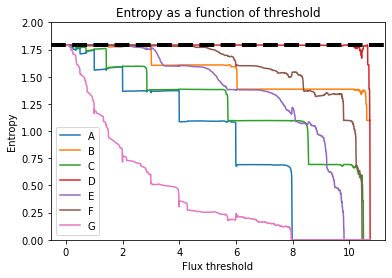

In [4]:


feature_importance=cs.feature_entropies(comb_space['Enzyme_G'],params,plotting=True)
#mu_random_entropy,si_random_entropy=cs.reference_noise_model(params,5)


In [10]:
feature_importance

{'vmax_forward_Enzyme_A': 0.5008292042727827,
 'vmax_forward_Enzyme_B': 0.13192604221085702,
 'vmax_forward_Enzyme_C': 0.316016084129888,
 'vmax_forward_Enzyme_D': 0.00295540765918223,
 'vmax_forward_Enzyme_E': 0.259164856440006,
 'vmax_forward_Enzyme_F': 0.12308575808690914,
 'vmax_forward_Enzyme_G': 0.761223136526839}

NameError: name 'area_A' is not defined

In [112]:
com

,vmax_forward_Enzyme_A,vmax_forward_Enzyme_B,vmax_forward_Enzyme_C,vmax_forward_Enzyme_D,vmax_forward_Enzyme_E,vmax_forward_Enzyme_F,vmax_forward_Enzyme_G,Enzyme_G
0,0.25,0.25,0.25,0.25,0.25,0.25,0.25,1.002459
1,0.25,0.25,0.25,0.25,0.25,0.25,0.50,0.501229
2,0.25,0.25,0.25,0.25,0.25,0.25,1.00,0.250614
3,0.25,0.25,0.25,0.25,0.25,0.25,1.50,0.167077
4,0.25,0.25,0.25,0.25,0.25,0.25,2.00,0.125307
...,...,...,...,...,...,...,...,...
279931,4.00,4.00,4.00,4.00,4.00,4.00,0.50,7.946944
279932,4.00,4.00,4.00,4.00,4.00,4.00,1.00,3.973489
279933,4.00,4.00,4.00,4.00,4.00,4.00,1.50,2.648993
279934,4.00,4.00,4.00,4.00,4.00,4.00,2.00,1.986744
